# GANによる以上画像検知のメカニズム
GANを用いた異常検知モデル Anormaly Detection with GAN の解説

## フォルダ準備
5章の画像生成とほぼ同じ．  
加えて7,8,5の画像を5まいずつフォルダtestに用意  
処理は5章のnotebookに移譲

## GANを用いた異常画像検出の必要性
異常のある画像はデータ収集が難しい  
正常画像のみで異常検出を可能にしたい  

## AnoGANの概要
Discriminatorだけ使うより，Generatorも使った方が精度が上がる手法がある  
それがAnoGAN  
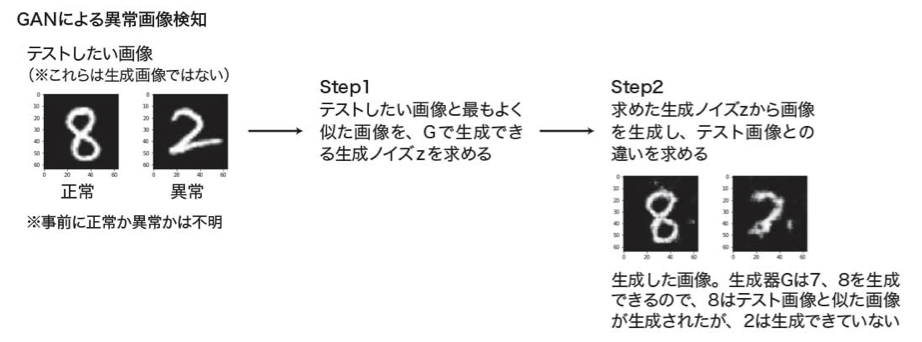

異常検出したい画像に近い画像を生成できるノイズを求めて生成．  
ちゃんとした画像が出力できれば正常，そうでなければ異常  
生成ノイズを求めるのにDを使う

# AnoGANの実装と異常検知の実施

## DCGANの学習
5章のDCGANをベースに使用する  
Dの出力の一つ手前の特徴量を使ってノイズを求めるので出力するよう書き換える

In [1]:
import os
from sklearn.datasets import fetch_openml
from PIL import Image
import numpy as np

import torch
from torch import nn, optim
from torch.utils import data
from torchvision import models, transforms
from IPython.display import clear_output
import time

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_dir = "../datasets/chapter5"
img_78_path = os.path.join(data_dir, "img_78")
test_path = os.path.join(data_dir, "test")

In [3]:
class Generator(nn.Module):
    def __init__(self, z_dim=20, image_size=64):
        super(Generator, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(z_dim, image_size*8, kernel_size=4, stride=1),
            nn.BatchNorm2d(image_size * 8),
            nn.ReLU(inplace=True) # ReLUの省メモリ化
        )
        
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(image_size*8, image_size*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 4),
            nn.ReLU(inplace=True)
        )
        
        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(image_size*4, image_size*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 2),
            nn.ReLU(inplace=True)
        )

        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(image_size*2, image_size, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True)
        )

        self.last = nn.Sequential(
            # 白黒画像なので出力チャネルは1つだけ
            nn.ConvTranspose2d(image_size, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        
    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)
        
        return out

In [4]:
class Discriminator(nn.Module):
    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()
        
        self.layer1 = nn.Sequential(
            # 白黒画像なので入力チャネルは1つだけ
            nn.Conv2d(1, image_size, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(image_size, image_size*2, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(image_size*2, image_size*4, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(image_size*4, image_size*8, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True)
        )

        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        # 最後の一つ手前の特徴量も出力する．
        feature = out
        
        # 2次元に変換して返す
        feature = feature.view(feature.size()[0], -1)
        
        out = self.last(out)
        
        return out, feature

In [5]:
def make_datapath_list():
    """
    学習，検証の画像データとアノテーションデータへのファイルパスリストを作成
    """
    
    train_img_list = []
    
    for img_idx in range(200):
        img_path=os.path.join(img_78_path, f"img_7_{img_idx}.jpg")
        train_img_list.append(img_path)
        
        img_path=os.path.join(img_78_path, f"img_8_{img_idx}.jpg")
        train_img_list.append(img_path)
    
    return train_img_list

In [6]:
class ImageTransform():
    """
    画像の前処理クラス
    """
    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
    
    def __call__(self, img):
        return self.data_transform(img)

class GAN_Img_Dataset(data.Dataset):
    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        return img_transformed

In [7]:
train_img_list = make_datapath_list()

mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(file_list=train_img_list, transform=ImageTransform(mean, std))

batch_size = 64
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

batch_iterator = iter(train_dataloader)
imges = next(batch_iterator)
print(imges.size()) # (M, C, H, W)

torch.Size([64, 1, 64, 64])


In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
G = Generator()
D = Discriminator()

G.apply(weights_init)
D.apply(weights_init)

# print(G, "\n", D)

学習の関数を実装，損失関数の計算もやる

In [10]:
def get_device(benchmark=True):
    # GPUが使用可能ならば設定
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス: ", device)
    
    # ネットワークがある程度固定であれば，高速化できる
    torch.backends.cudnn.benchmark = benchmark
    
    return device

In [11]:
def train_model(G, D, dataloader, num_epochs, device=None):
    
    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    z_dim = 20
    
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])
    
    criterion = nn.BCEWithLogitsLoss(reduction='mean')
    
    if device:
        G.to(device)
        D.to(device)
    G.train()
    D.train()
    
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    
    iteration = 1
    logs = []
    for epoch in range(num_epochs):
        
        t_epoch_start = time.time()
        epoch_g_loss = 0.0
        epoch_d_loss = 0.0
        
        clear_output()
        print("-----------------")
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-----------------")
        print(' (train) ')
        
        for images in dataloader:
            
            mini_batch_size = images.size()[0]
            if mini_batch_size == 1:
                continue
            
            
            #################
            # データの作成
            #################
            label_real = torch.full((mini_batch_size,), 1)
            label_fake = torch.full((mini_batch_size,), 0)
            input_d_z = torch.randn(mini_batch_size, z_dim)
            input_d_z = input_d_z.view(input_d_z.size(0), input_d_z.size(1), 1, 1)
            input_g_z = torch.randn(mini_batch_size, z_dim)
            input_g_z = input_g_z.view(input_g_z.size(0), input_g_z.size(1), 1, 1)
            
            if device:
                images = images.to(device)
                label_real = label_real.to(device)
                label_fake = label_fake.to(device)
                input_d_z = input_d_z.to(device)
                input_g_z = input_g_z.to(device)

            
            #################
            # Discriminator
            #################
            
            # Dの出力が増えるので注意！
            d_out_real, _ = D(images)
            d_out_fake, _ = D(G(input_d_z))
            
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake
            
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()
            
            
            #################
            # Generator
            #################
            
            # Dの出力が増えるので注意！
            d_out_fake, _ = D(G(input_g_z))
            
            g_loss = criterion(d_out_fake.view(-1), label_real)
            
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
            
            
            #################
            # 記録
            #################
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1
        
        
        print("-----------------")
        
        d_loss = epoch_d_loss / batch_size
        g_loss = epoch_g_loss / batch_size
        print(f"epoch {epoch+1} | D loss: {d_loss} | G loss: {g_loss}")
        
        t_epoch_finish = time.time()
        print(f"timer: {t_epoch_finish - t_epoch_start}")
        t_epoch_start = time.time()
    
    return G, D

学習を開始

In [12]:
device = get_device()
G_update, D_update = train_model(
    G=G,
    D=D,
    dataloader=train_dataloader,
    num_epochs=200,
    device=device
)

-----------------
Epoch 200/200
-----------------
 (train) 
-----------------
epoch 200 | D loss: 0.030885512242093682 | G loss: 0.45321333408355713
timer: 0.3801114559173584


学習の結果

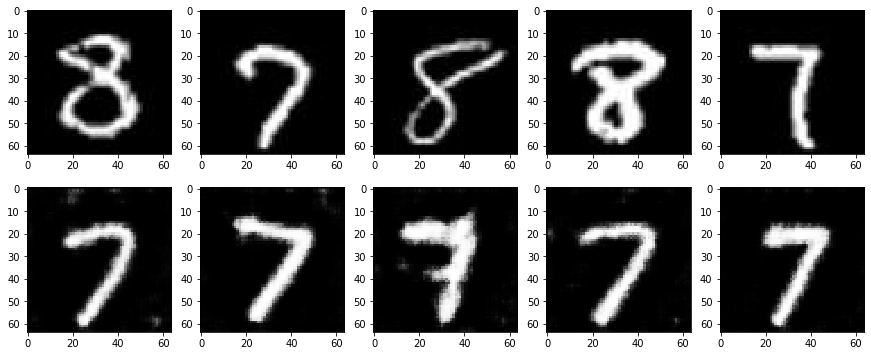

In [13]:
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)
fake_images = G_update(fixed_z.to(device))

batch_iterator = iter(train_dataloader)
images = next(batch_iterator)

fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段は訓練データ
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i][0].cpu().detach().numpy(), 'gray')
    
    # 下段は生成データ
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')

## AnoGANの生成乱数$z$の求め方
適当なノイズ$z$から生成した画像とテスト画像のピクセルレベルでの違いを損失として小さくする 

  
損失値に対する$z$の微分値に従い$z$を更新していく．  
これでテスト画像に似た画像を生成できるようになっていく．  
最終的にテスト画像に似た画像を生成できる入力ノイズ$z$が求まる．

## AnoGANの損失関数
生成画像とテスト画像の違いによる誤差をresidual lossと呼ぶ  
residual lossだけでは学習が進みづらいので，discrimination lossを加える  
Dの最終出力の一つ前の特徴量の生成画像とテスト画像の違いによる誤差である．  
$$ loss = (1 - \lambda) residual loss + \lambda \space discrimination loss $$
ここで$\lambda$はresidual lossとdiscrimination lossのバランスをコントロールする変数で論文では0.1が使用されている．

In [14]:
def anomaly_score(x, fake_img, D, Lambda=0.1):
    
    # 生成画像とテスト画像のピクセルレベルの絶対差の合計
    residual_loss = torch.abs(x - fake_img)
    residual_loss = residual_loss.view(residual_loss.size()[0], -1)
    residual_loss = torch.sum(residual_loss, dim=1)
    
    # 生成画像とテスト画像をDに入力し，特徴量を取得
    _, x_feature = D(x)
    _, G_feature = D(fake_img)
    
    # 生成画像の特徴量とテスト画像の特徴量の絶対差の合計
    discrimination_loss = torch.abs(x_feature - G_feature)
    discrimination_loss = discrimination_loss.view(discrimination_loss.size()[0], -1)
    discrimination_loss = torch.sum(discrimination_loss, dim=1)
    
    # 最終的な損失
    loss_each = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    
    # ミニバッチ全部の損失を求める
    total_loss = torch.sum(loss_each)
    
    return total_loss, loss_each, residual_loss

## AnoGANの学習の実装と異常検知の実施
テストデータ用のDataLoaderを作成

In [15]:
def make_test_datapath_list():
    train_img_list = list()
    for i in range(5):
        img_path = os.path.join(test_path, f"img_7_{i}.jpg")
        train_img_list.append(img_path)
        
        img_path = os.path.join(test_path, f"img_8_{i}.jpg")
        train_img_list.append(img_path)
        
        img_path = os.path.join(test_path, f"img_2_{i}.jpg")
        train_img_list.append(img_path)
        
    return train_img_list

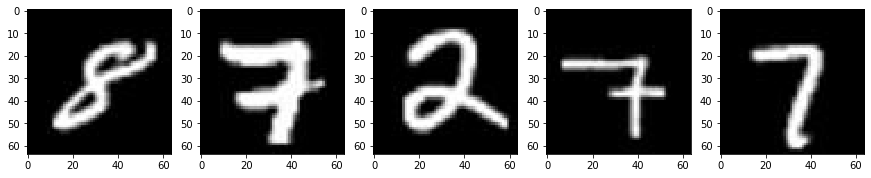

In [26]:
test_img_list = make_test_datapath_list()

mean = (0.5,)
std = (0.5,)
test_dataset = GAN_Img_Dataset(
    file_list=test_img_list,
    transform=ImageTransform(mean, std)
)

batch_size = 5
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True
)

# テストデータの確認
batch_iterator = iter(test_dataloader)
images = next(batch_iterator)

fig = plt.figure(figsize=(15, 6))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i][0].cpu().detach().numpy(), 'gray')

学習を実施し，テスト画像に似たノイズ$z$を求める

In [27]:
x = images[:5]
z = torch.randn(5, 20)
z = z.view(z.size(0), z.size(1), 1, 1)

if device:
    x = x.to(device)
    z = z.to(device)

# 入力ノイズについても微分を求められるようにzの勾配を計算可能にする
z.requires_grad = True

# 変数zを更新できるようにzの最適化関数を設定
z_optimizer = torch.optim.Adam([z], lr=1e-3)

# zを反復的に求める
for epoch in range(5000+1):
    fake_img = G_update(z)
    loss, _, _ = anomaly_score(x, fake_img, D_update, Lambda=0.1)
    
    z_optimizer.zero_grad()
    loss.backward()
    z_optimizer.step()
    
    if epoch % 1000 == 0:
        print(f"epoch {epoch} | loss: {loss.item()}")

epoch 0 | loss: 5263.400390625
epoch 1000 | loss: 3430.718505859375
epoch 2000 | loss: 3037.10693359375
epoch 3000 | loss: 2824.741943359375
epoch 4000 | loss: 2721.269775390625
epoch 5000 | loss: 2689.888427734375


最後に，求めたノイズ$z$をGに入力し画像を生成してみる  
そして損失がどうなっているかを求め，元テスト画像との差を視覚化

total loss: [549. 597. 761. 621. 162.]


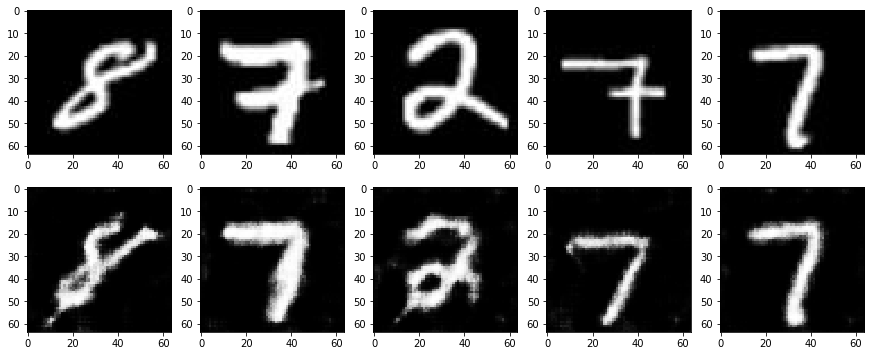

In [28]:
fake_img = G_update(z)

loss, loss_each, residual_loss_each = anomaly_score(x, fake_img, D_update, Lambda=0.1)
loss_each = loss_each.cpu().detach().numpy()
print("total loss:", np.round(loss_each, 0))

fig = plt.figure(figsize=(15, 6))
for i in range(5):
    # 上段にテストデータを
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i][0].cpu().detach().numpy(), 'gray')
    
    # 下段に生成データを表示する
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_img[i][0].cpu().detach().numpy(), 'gray')

7,8のtotal lossに比べて，2のロスは比較的大きいことがわかる．  
画像を見ても異常データである2はうまく生成できておらず異常の検出が行える  
ロスが大きな画像については人間が直接目で見て判断するのが実用的．  
  
しかし，$z$を求めるのに反復処理で時間がかかる．  
これを解決するために次のEfficient GANがある．